In [1]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
import control as ct
from casadi import *
import dpilqr
import itertools

In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

In [204]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)


In [205]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = sparse.lil_matrix((6*n_agent, 6*n_agent))
    B_tot = sparse.lil_matrix((6*n_agent, 3*n_agent))
    A = sparse.csc_matrix([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = sparse.csc_matrix([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot
        
        
    

In [206]:
A_tot,B_tot = linear_kinodynamics(0.1,3)

In [207]:
from solvers import util

In [208]:
x0,xr = util.paper_setup_3_quads()

In [209]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))


In [210]:
def diag_block_mat_booliex(L):
    shp = L[0].shape
    mask = np.kron(np.eye(len(L)), np.ones(shp))==1
    out = np.zeros(np.asarray(shp)*len(L),dtype=int)
    out[mask] = np.concatenate(L).ravel()
    return out

In [211]:
def get_coll_cost(x, x_dims, radius, weight=200):
    distances = compute_pairwise_distance(x0, x_dims)
    pair_costs = np.fmin(np.zeros(1), distances - radius) ** 2
    return pair_costs.sum()*weight

In [212]:
def construct_P(P_base, num_agents):
    n = 6  # Dimension of state vector for each agent
    for i in range(num_agents):
        for j in range(num_agents):
            if i !=j:
                # Determine the position iices of agents i and j in the state vector
                pos_i = n * i  # Assuming each agent has 6 state vector components (3 positions + 3 velocities)
                pos_j = n * j

                # Modify the corresponding elements in P to incorporate collision avoidance
                # P_base[pos_i:pos_i + 3, pos_i:pos_i + 3] += np.eye(3) # (pos_i, pos_i)
                P_base[pos_i:pos_i + 3, pos_j:pos_j + 3] = np.eye(3)*50 # (pos_i, pos_j)
                P_base[pos_j:pos_j + 3, pos_i:pos_i + 3] = -np.eye(3)*50  # (pos_j, pos_i)
                # P_base[pos_j:pos_j + 3, pos_j:pos_j + 3] += np.eye(3) # (pos_j, pos_j)

    return P_base

## Solving the consensus ADMM problem with OSQP

In [213]:
import cvxpy as cp

In [214]:
def compute_pairwise_distance_CVX(X, x_dims, n_dims):
    """Analog to the above whenever some agents only use distance in the x-y plane"""
    CYLiER_RADIUS = 0.2

    n_states = x_dims[0]
    n_agents = len(x_dims)
    distances = []
    eps = 1e-3

    for i, n_dim_i in zip(range(n_agents), n_dims):
        for j, n_dim_j in zip(range(i + 1, n_agents), n_dims[i + 1 :]):
            n_dim = min(n_dim_i, n_dim_j)

            Xi = X[i * n_states : i * n_states + n_dim]
            Xj = X[j * n_states : j * n_states + n_dim]
            dX = Xi-Xj

            if n_dim == 3:
                # distances.append(cp.sqrt(dX[0]**2+dX[1]**2+dX[2]**2+eps))
                distances.append(cp.norm(dX))
            else:
                distances.append(cp.sqrt(dX[0]**2+dX[1]**2 + eps)+CYLiER_RADIUS)
    
    return distances

In [289]:
# Solving a MPC problem with OSQP solver at each iteration
N = 15

cost = 0
constr = []
x0,xr = util.paper_setup_3_quads()

radius = 0.3

# X_full = np.zeros((nsim+1,nx))
X_full = np.zeros((0,nx))
X_full = np.r_[X_full,x0.reshape(1,-1)]
xi = x0.flatten()
xr = xr.flatten()
Ad,Bd = linear_kinodynamics(0.1, 3)
n_agents = 3
nx = n_agents * 6
nu = n_agents * 3
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*n_agents)
QN = Q*500
R = 0.1*sparse.eye(nu)

iter = 0
x_dims = [n_states]*n_agents
n_dims = [3]*n_agents
while not np.all(dpilqr.distance_to_goal(xi,xr,n_agents,6,3) < 0.1) and (iter <= 150):
# for _ in range(50):
    x = cp.Variable((N+1,nx))
    u = cp.Variable((N,nu))
    cost = 0
    constr = []

    for t in range(N):

        cost += cp.quad_form(x[t+1,:]-xr.flatten(),Q) + cp.quad_form(u[t,:],R)
        constr += [x[t + 1,:] == Ad @ x[t,:] + Bd @ u[t, :]]
        constr += [u[t,:] <= np.tile(np.array([3, 3, 3]),(n_agents,)) ]
        constr += [np.tile(np.array([-3, -3, -3]),(n_agents,)) <= u[t, :]]
        # constr += [x[t, :] <= np.tile(np.array([np.inf, np.inf, np.inf, 2, 2, 2]),(n_agents,))]
        # constr += [np.tile(-np.array([np.inf, np.inf, np.inf, 2, 2, 2]),(n_agents,)) <= x[t,:]]
        
        # Linearized collision avoidance constraints
        if iter > 0:
            x_prev = X_full[iter-1]
            print(f'x_prev has shape {x_prev.shape}')
            for i in range(n_agents):
                for j in range(n_agents):
                    if j != i:
                        #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                        # A sequential convex programming approach" for the linearization step;
                        constr += [cp.norm(x_prev[j*n_states:j*n_states+3]-  \
                                           x_prev[i*n_states:i*n_states+3]) + \
                                (x_prev[j*n_states:j*n_states+3].T- \
                                 x_prev[i*n_states:i*n_states+3].T)/cp.norm(x_prev[j*n_states:j*n_states+3] \
                                -x_prev[i*n_states:i*n_states+3])@ \
                                   ((x[t,j*n_states:j*n_states+3]-x[t,i*n_states:i*n_states+3])- \
                                    (x_prev[j*n_states:j*n_states+3]-x_prev[i*n_states:i*n_states+3])) >= radius]

    cost += cp.quad_form((x[-1,:]-xr.flatten()),QN)    

    constr += [x[0, :] == xi]

    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose=True)

    u_trj = u.value
    x_trj = x.value
    ctrl = u_trj[1]
    xi = Ad@xi + Bd@ctrl
    X_full = np.r_[X_full,xi.reshape(1,-1)]
    
    iter +=1



                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 13 01:20:17 PM: Your problem has 423 variables, 46 constraints, and 0 parameters.
(CVXPY) Jun 13 01:20:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 13 01:20:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 13 01:20:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 13 01:20:17 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 13 01:20:17 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

KeyboardInterrupt: 

In [216]:
X_full.shape

(123, 18)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


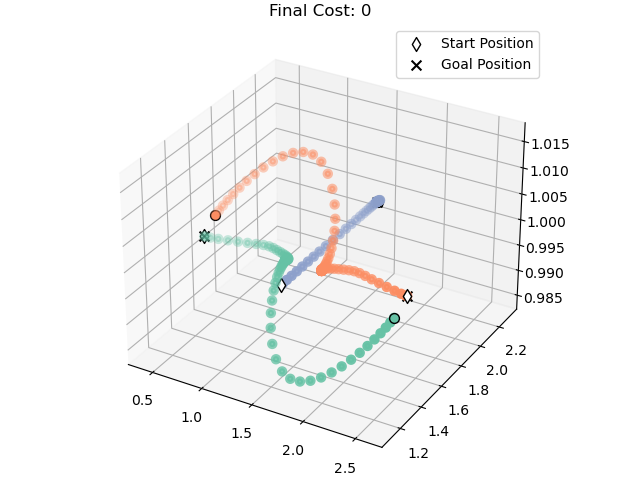

In [217]:
%matplotlib ipympl
plt.figure(dpi=100)
dpilqr.plot_solve(X_full,0,xr,[6,6,6],True,3)
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.savefig('MPC_with_OSQP.png')

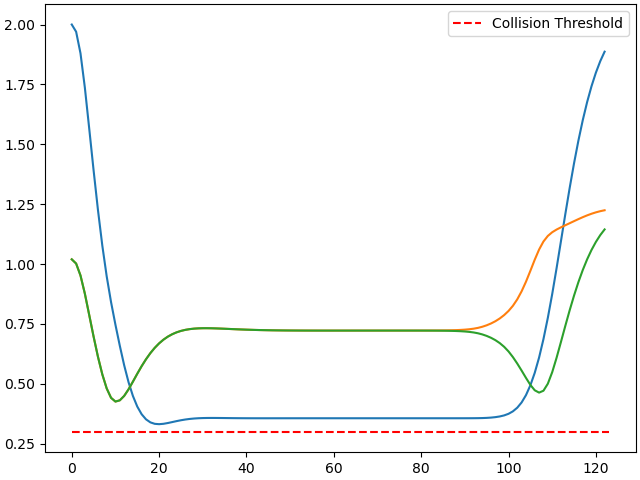

In [219]:
plt.figure(dpi=100)
plt.plot(np.arange(0,X_full.shape[0]),dpilqr.compute_pairwise_distance(X_full,[6,6,6],3));
plt.hlines(0.3,0, X_full.shape[0],linestyle='--', color='r',label='Collision Threshold')
plt.legend()

### Consensus-ADMM MPC

In [220]:
from solvers import util
from multiprocessing import Process, Pipe
import cvxpy as cp
# from multi_agent_scp import *

In [221]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [294]:
# Number of terms f_i.
N = 3
Ad,Bd = linear_kinodynamics(0.1,N)
# A list of all the f_i.
T = 10 #Prediction horizon
n_states = 6
n_inputs = 3
Q_try = np.eye(n_states*N)
R_try = np.eye(n_inputs*N)*0.1
n = n_states*N

x0, xr = util.paper_setup_3_quads()


# f_list = []

nx = n_states*N
nu = n_inputs*N
# x = cp.Variable(((T+1)*nx, 1))
# u_input = cp.Variable((T*nu, 1))


    
def run_worker(f, pipe):

    y_state = cp.Variable(((T+1) * nx + T * nu, 1))

    Q = np.diag([1., 1., 1., 1., 1., 1.]* N)
    x_dims = [6]*N
    QN = Q*10

    xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
    u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) #This is the scaled Lagrange multiplier

    rho = 1
    f += (rho/2)*cp.sum_squares(y_state.flatten() - xbar + u)
    x0, xr = util.paper_setup_3_quads()
    constr = []
    constr += [y_state[0:nx] == x0]

    for k in range(T):
        constr += [y_state[(k+1)*nx:(k+2)*nx] == Ad @ y_state[k * nx:(k+1) * nx] \
                                               + Bd @ y_state[(T+1)*nx + k * nu: (T+1) * nx + (k+1) * nu]]    
    radius = 0.3   
    # ADMM loop
    iter = 0
    while True:
        try:
            #Solve local constrained problem with OSQP solver in CVXPY
            if iter > 0 :
                pos_prev = state_prev[iter-1]
                for i in range(n_agents):
                    for j in range(n_agents):
                        if j != i:
                            #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                            # A sequential convex programming approach" for the linearization step;
                            for t in range(0,T):

                                constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
                                                   pos_prev[i*n_states:i*n_states+3]) + \
                                        (pos_prev[j*n_states:j*n_states+3].T- \
                                         pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
                                        -pos_prev[i*n_states:i*n_states+3])@ \
                                           ((cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[t,j*n_states:j*n_states+3] \
                                            -cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[t,i*n_states:i*n_states+3])- \
                                (pos_prev[j*n_states:j*n_states+3]-pos_prev[i*n_states:i*n_states+3]).flatten()) >= radius]


            prox = cp.Problem(cp.Minimize(f),constr)
            prox.solve()
            pipe.send(y_state.value.flatten())
            xbar.value = pipe.recv() #receive the averaged result from the main process.
            # print(f'xbar has shape {xbar.value.shape} \n')
            # print(f'y_state has shape {y_state.value.shape} \n')
            u.value += y_state.value.flatten() - xbar.value


            state_prev = xbar.value[0:(T+1)*nx]
            state_prev = state_prev.reshape((T+1, nx))

            iter += 1
            print(f'Current iteration is {iter}')
        except EOFError:
            print("Connection closed.")
            break

# Setup the workers.

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(construct_obj(nx, nu, xr, T, Q_try, R_try, N)[i], remote))]
    procs[-1].start()

# ADMM loop.
solution_list = []
for i in range(10):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)

[p.terminate() for p in procs]

Current iteration is 1Current iteration is 1Current iteration is 1


Current iteration is 2Current iteration is 2Current iteration is 2


Current iteration is 3Current iteration is 3Current iteration is 3


Current iteration is 4Current iteration is 4Current iteration is 4




/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Current iteration is 5Current iteration is 5Current iteration is 5


Current iteration is 6Current iteration is 6Current iteration is 6


Current iteration is 7Current iteration is 7Current iteration is 7




Process Process-160:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3761/3692055369.py", line 78, in run_worker
    pipe.send(y_state.value.flatten())
Process Process-158:
AttributeError: 'NoneType' object has no attribute 'flatten'
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-159:
  File "/tmp/ipykernel_3761/3692055369.py", line 78, in run_worker
    pipe.send(y_state.value.flatten())
Traceback 

EOFError: 

In [296]:
len(solution_list)

7

In [319]:
class AdmmMPC:
    def __init__(self, nx, nu, x0, xr, T, Q, R, Qf, N, Ad, Bd, radius = 0.3, MAX_ITER=10):
        self.nx = nx #Total No. of states
        self.nu = nu #Total No. of inputs
        self.xr = xr #Final cond.
        self.x0 = x0 #Initial cond.
        self.N = N #No. of agents
        self.T = T #Horizon
        self.y_state = cp.Variable((((T+1)*self.nx + T * self.nu, 1))) #Augmented state variable
        self.Q = Q #Positive definite
        self.R = R #Positive definite ..
        self.Qf = Qf #Positive definite
        self.radius = radius #Collision threshold radius
        self.Ad = Ad #State matrix
        self.Bd = Bd #Input matrix
        self.MAX_ITER = MAX_ITER
        
        
    def objective_admm(self):
    
        """Compact form of quadratic tracking cost"""
        """y_aug: (x(0),x(1),...,x(N),u(0),...,u(N-1))"""
        # y_aug = self.y_state

        objective = 0

        # Quadratic objective
        P = sparse.block_diag([sparse.kron(sparse.eye(self.T), self.Q), self.Qf,
                           sparse.kron(sparse.eye(self.T), self.R)], format='csc')
        # linear objective
        q = np.hstack([np.kron(np.ones(self.T), -self.Q@self.xr.flatten()), -self.Qf@self.xr.flatten(), np.zeros(self.T*self.nu)])

        objective += cp.quad_form(self.y_state, P) + q.T @ self.y_state

        return objective
        

    def construct_obj_i(self):
        f_list = []
        for id in range(N):
            cost_i = self.objective_admm()
            f_list.append(cost_i)

        return f_list
    
    
    def run_worker(self, f, pipe):
  
        x_dims = [6]*self.N

        self.xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
        self.u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) #This is the scaled Lagrange multiplier

        rho = 1
        f += (rho/2)*cp.sum_squares(y_state.flatten() - self.xbar + self.u)
        constr = []
        constr += [self.y_state[0:nx] == x0]

        for k in range(T):
            constr += [self.y_state[(k+1) * nx: (k+2) * nx] == self.Ad @ self.y_state[k * nx:(k+1) * nx] \
                                                   + self.Bd @ self.y_state[(T+1)*nx + k * nu: (T+1) * nx + (k+1) * nu]]      
        # ADMM loop
        iter = 0
        while True:
            try:
                #Solve local constrained problem with OSQP solver in CVXPY
                if iter > 0 :
                    pos_prev = state_prev[iter-1]
                    for i in range(n_agents):
                        for j in range(n_agents):
                            if j != i:
                                #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                                # A sequential convex programming approach" for the linearization step;
                                for t in range(0,T):

                                    constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
                                                       pos_prev[i*n_states:i*n_states+3]) + \
                                            (pos_prev[j*n_states:j*n_states+3].T- \
                                             pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
                                            -pos_prev[i*n_states:i*n_states+3])@ \
                                               ((cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[t,j*n_states:j*n_states+3] \
                                                -cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[t,i*n_states:i*n_states+3])- \
                                    (pos_prev[j*n_states:j*n_states+3]-pos_prev[i*n_states:i*n_states+3]).flatten()) >= self.radius]


                prox = cp.Problem(cp.Minimize(f),constr)
                prox.solve()
                pipe.send(self.y_state.value.flatten())
                self.xbar.value = pipe.recv() #receive the averaged result from the main process.
                # print(f'xbar has shape {xbar.value.shape} \n')
                # print(f'y_state has shape {y_state.value.shape} \n')
                self.u.value += self.y_state.value.flatten() - self.xbar.value


                state_prev = self.xbar.value[0:(T+1)*nx]
                state_prev = state_prev.reshape((T+1, nx))

                iter += 1
                print(f'Current iteration is {iter}')
            except EOFError:
                print("Connection closed.")
                break
                
    
    def run(self):
        # ADMM loop.
        
        pipes = []
        procs = []
        for i in range(self.N):
            local, remote = Pipe()
            pipes += [local]
            procs += [Process(target=run_worker, args=(self.construct_obj_i()[i], remote))]
            procs[-1].start()
        
        solution_list = []
        for i in range(self.MAX_ITER):
            # Gather and average xi

            self.xbar = sum(pipe.recv() for pipe in pipes)/N
            # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

            solution_list.append(self.xbar)
            # print(f'average of xbar is {np.mean(xbar)}\n')

            # Scatter xbar
            for pipe in pipes:
                pipe.send(self.xbar)
        
        [p.terminate() for p in procs]
        
        
        return solution_list

        


In [320]:
N = 3
Ad,Bd = linear_kinodynamics(0.1,N)
# A list of all the f_i.
T = 10 #Prediction horizon
n_states = 6
n_inputs = 3
# Q_try = np.eye(n_states*N)
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*n_agents)
QN = Q*500
R = 0.1*sparse.eye(nu)
n = n_states*N

x0, xr = util.paper_setup_3_quads()


# f_list = []

nx = n_states*N
nu = n_inputs*N

In [321]:
sub_problem = AdmmMPC(nx, nu, x0, xr, T, Q, R, QN, N, Ad, Bd)

In [322]:
sub_problem.run()

Current iteration is 1Current iteration is 1Current iteration is 1




/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Current iteration is 2Current iteration is 2Current iteration is 2


Current iteration is 3Current iteration is 3Current iteration is 3


Current iteration is 4Current iteration is 4Current iteration is 4


Current iteration is 5Current iteration is 5Current iteration is 5


Current iteration is 6Current iteration is 6Current iteration is 6


Current iteration is 7Current iteration is 7Current iteration is 7




Process Process-166:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3761/3692055369.py", line 78, in run_worker
    pipe.send(y_state.value.flatten())
AttributeError: 'NoneType' object has no attribute 'flatten'
Process Process-165:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3761/3692055369.py", line 78, in run_worker
    pipe.send(y_state.value.flatten())
AttributeError: 'NoneType' obje

EOFError: 